# CNN Movie Polarity Detection

### dataset url : https://www.cs.cornell.edu/people/pabo/movie-review-data/

## search  : keras text_generation

In [34]:
import os
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as PLT
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Input,Dense,Flatten,Embedding,Conv1D,MaxPool1D,concatenate,Dropout,Conv2D,MaxPool2D,Activation,BatchNormalization

In [6]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[]


In [7]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/masoud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from string import punctuation
def punctuation_cleaner(string):
    global punctuation
    punctuation = punctuation+'\n\\//'
    s = str.maketrans('','',punctuation)
    return string.translate(s)

stopwords_en = stopwords.words('english')

In [51]:
DF = pd.read_csv('../../../datasets/IMDB Dataset.csv')
DF.rename(columns={'review':'text','sentiment':'target'},inplace=True)
DF = DF.drop_duplicates()
DF.head()

,text,target
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [53]:
def html_cleaner(row):
    soup = BeautifulSoup(row['text'], 'html.parser')
    row['text'] = soup.get_text()
    return row

def target_encoder(row):
    row['target'] = 1 if row['target'] =='positive' else 0
    return row

DF = DF.apply(html_cleaner,axis=1)
DF = DF.apply(target_encoder,axis=1)

/home/masoud/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [54]:
def text_preprocess(row):
    text = row['text']
    text = punctuation_cleaner(text)
    text = word_tokenize(text)
    text = [w for w in text if w not in stopwords_en]
    text = [lemmatizer.lemmatize(w) for w in text]
    text = set([stemmer.stem(w) for w in text])
    row['text'] = text
    return row

DF = DF.apply(html_cleaner,axis=1)

In [55]:
DF.shape

(49582, 2)

In [56]:
DF.head()

,text,target
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [57]:
max_len = DF['text'].str.split(' ').str.len().max() 

In [58]:
X_train,X_test,Y_train,Y_test = train_test_split(DF.iloc[:,:-1],DF['target'],test_size=.3)

In [59]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])

In [60]:
vocab_len = len(tokenizer.word_index) + 1 

In [61]:
X_train = tokenizer.texts_to_sequences(X_train['text'])
X_train = pad_sequences(X_train,maxlen=max_len,padding='post')

In [62]:
X_test = tokenizer.texts_to_sequences(X_test['text'])
X_test = pad_sequences(X_test,maxlen=max_len,padding='post')

In [63]:
X_train

array([[   10,    14,     6, ...,     0,     0,     0],
       [29842,     3,   902, ...,     0,     0,     0],
       [14456,   408,    21, ...,     0,     0,     0],
       ...,
       [   10,    18,     6, ...,     0,     0,     0],
       [  312,    71,   877, ...,     0,     0,     0],
       [   27,   206,  1000, ...,     0,     0,     0]], dtype=int32)

In [64]:
model = Sequential([
    Embedding(input_dim=vocab_len,output_dim=400,input_shape=(max_len,)),
    Conv1D(filters=64, kernel_size=32, activation='relu'),
    Dropout(.4),
    MaxPool1D(pool_size=20),
    Flatten(),
    Dense(100,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer = Adam(.001),
    metrics=['accuracy']
)

2023-03-09 19:13:03.875580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
history = model.fit(X_train,Y_train,epochs=10, batch_size=20,validation_data=(X_test,Y_test))

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1389, 500)         13754000  
                                                                 
 conv1d_5 (Conv1D)           (None, 1358, 64)          1024064   
                                                                 
 dropout_2 (Dropout)         (None, 1358, 64)          0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 679, 64)          0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 43456)             0         
                                                                 
 dense_7 (Dense)             (None, 10)                434570    
                                                      

## Multi Channel

In [20]:
input1 = Input(shape=(max_len,))
embeding1 = Embedding(vocab_len,500)(input1)
conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embeding1)
# dropout1 = Dropout(.5)(conv1)
maxpool1 = MaxPool1D(pool_size=2)(conv1)
flat1 = Flatten()(maxpool1)

input2 = Input(shape=(max_len,))
embeding2 = Embedding(vocab_len,500)(input2)
conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embeding2)
# dropout2 = Dropout(.5)(conv2)
maxpool2 = MaxPool1D(pool_size=2)(conv2)
flat2 = Flatten()(maxpool2)

input3 = Input(shape=(max_len,))
embeding3 = Embedding(vocab_len,500)(input3)
conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embeding3)
# dropout3 = Dropout(.5)(conv3)
maxpool3 = MaxPool1D(pool_size=2)(conv3)
flat3 = Flatten()(maxpool3)

flatX = concatenate([flat1,flat2,flat3])
dense1 = Dense(100,activation='relu')(flatX)
dense2 = Dense(10,activation='relu')(dense1)
output = Dense(1,activation='sigmoid')(dense2)

In [21]:
model = Model(inputs=[input1,input2,input3],outputs=output)
model.compile(
    loss='binary_crossentropy',
    optimizer = Adam(),
    metrics=['accuracy']
)

In [125]:
plot_model(model,show_layer_names=False,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
history = model.fit(
    [X_train,X_train,X_train],
    Y_train,
    epochs=5,
    batch_size=20,
    validation_data=([X_test,X_test,X_test],Y_test)
)

Epoch 1/5
70/70 [==============================] - 3s 41ms/step - loss: 0.2921 - accuracy: 0.8536 - val_loss: 0.0267 - val_accuracy: 0.9900
Epoch 2/5
70/70 [==============================] - 3s 39ms/step - loss: 0.0110 - accuracy: 0.9971 - val_loss: 0.0273 - val_accuracy: 0.9867
Epoch 3/5
70/70 [==============================] - 3s 39ms/step - loss: 0.0013 - accuracy: 0.9993 - val_loss: 0.0140 - val_accuracy: 0.9917
Epoch 4/5
70/70 [==============================] - 3s 39ms/step - loss: 2.7489e-04 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 0.9917
Epoch 5/5
70/70 [==============================] - 3s 40ms/step - loss: 1.5077e-04 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 0.9917


In [24]:
model.save('../../../datasets/models/movie_polarity_detection.h5')

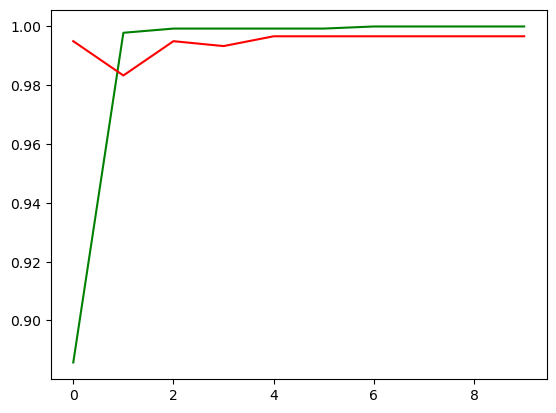

In [33]:
PLT.plot(history.history['accuracy'], color='green', label='train data')
PLT.plot(history.history['val_accuracy'], color='red', label='test data')